In [15]:
import sys, os
sys.path.append(os.path.abspath('../utils/'))

from train_utils import *
import numpy as np
layers = []
layer = {}
layer['inp_modes'] = np.array([4, 7, 4, 7], dtype='int32')
layer['out_modes'] = np.array([5, 5, 8, 4], dtype='int32')
layers.append(layer)

layer['inp_modes'] = layer['out_modes']
layer['out_modes'] = np.array([4, 4, 4, 4], dtype='int32')
layers.append(layer)


# load test error results
path_name = '/home/roseyu/Python/TensorCompress/experiments/'
with open(path_name + 'mnist/2-layer-tt/results/res_tt', 'r') as f:
    line = f.read()
    tokens = line.strip().split()
tt_err = np.array([float(x) for x in tokens])


with open(path_name + 'mnist/2-layer-tucker/results/res_tucker', 'r') as f:
    line = f.read()
    tokens = line.strip().split()
tucker_err = np.array([float(x) for x in tokens])

with open(path_name + 'mnist/2-layer-cp/results/res_cp', 'r') as f:
    line = f.read()
    tokens = line.strip().split()
cp_err = np.array([float(x) for x in tokens])
cp_err = np.delete(cp_err,5)


with open(path_name + 'mnist/2-layer-mf/results/res_mf', 'r') as f:
    line = f.read()
    tokens = line.strip().split()
mf_err = np.array([float(x) for x in tokens])

tt_compres = np.zeros((5,))
tucker_compres = np.zeros((5,))
cp_compres = np.zeros((5,))
mf_compres = np.zeros((5,))
i = 0
for rank_val in range(1,6):
    tt_layer_ranks = [np.hstack(([1],np.ones(3, dtype='int32')*rank_val,[1])),
                              np.hstack(([1],np.ones(3, dtype='int32')*rank_val,[1]))]
    tt_compres[i] = compres_ratio_tt(layers, tt_layer_ranks)

    tucker_layer_ranks = [np.ones(4, dtype='int32')*rank_val, np.ones(4, dtype='int32')*rank_val]
    tucker_compres[i] = compres_ratio_tucker(layers, tucker_layer_ranks)
    
    # change the last point of compression due to slow decay
    if rank_val ==5:
        rank_val_cp = 15
    else:
        rank_val_cp = rank_val
    
    cp_layer_ranks = [rank_val_cp, rank_val_cp]
    cp_compres[i] = compres_ratio_cp(layers, cp_layer_ranks)
    
    mf_layer_ranks = [rank_val, rank_val]
    mf_compres[i] = compres_ratio_mf(layers, mf_layer_ranks)
    
    i = i+1
print tt_compres, 1-tt_err
print tucker_compres, 1-tucker_err
print cp_compres, 1-cp_err
print mf_compres, 1-mf_err

[ 2327.27272727   731.42857143   355.55555556   209.83606557   138.37837838] [ 0.947   0.949   0.9615  0.9556  0.9671]
[ 2301.12359551  1066.66666667   593.62318841   336.84210526   192.30046948] [ 0.824   0.9165  0.9521  0.9559  0.9618]
[ 2301.12359551  1157.06214689   772.83018868   580.16997167   155.0340651 ] [ 0.6277  0.7635  0.8618  0.878   0.8847]
[ 193.93939394   96.96969697   64.64646465   48.48484848   38.78787879] [ 0.4263  0.7388  0.832   0.9061  0.925 ]


### publication quality configuration

In [16]:
from matplotlib import rcParams
params = {
   'axes.labelsize': 20,
   'text.fontsize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5],
   'lines.linewidth': 3.0,
   'lines.markersize' : 10
   }
rcParams.update(params)
import brewer2mpl

# brewer2mpl.get_map args: set name  set type  number of colors
bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
colors = bmap.mpl_colors

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


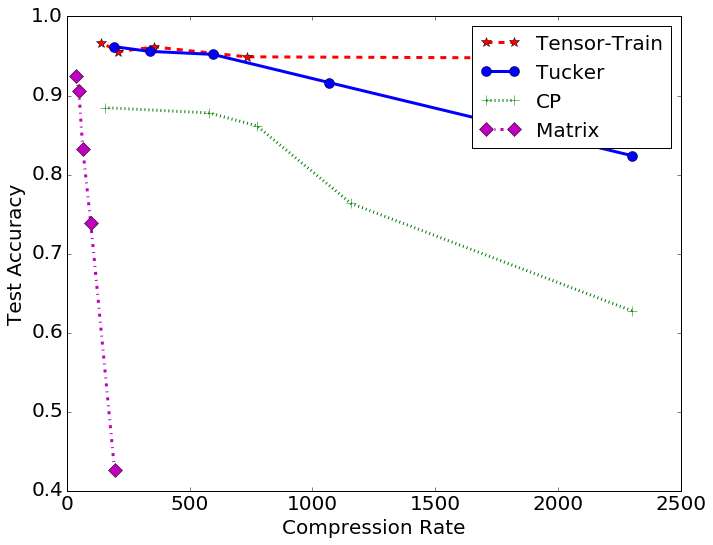

In [18]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(11, 8.5), dpi=600)
matplotlib.rcParams.update({'font.size': 20})
plt.plot(tt_compres, 1.0-tt_err, 'r*--', tucker_compres, 1.0-tucker_err, 'bo-', 
         cp_compres, 1.0-cp_err, 'g+:', mf_compres, 1.0-mf_err, 'mD-.')
plt.legend(['Tensor-Train', 'Tucker', 'CP','Matrix'])
plt.xlabel('Compression Rate')
plt.ylabel('Test Accuracy')
plt.savefig('acc_ratio_cmp.pdf', format='pdf')

## Plot LeNet300 with fine-grained compression ratio

In [22]:
# load test error results
path_name = '/home/roseyu/Python/TensorCompress/experiments/'
mf_compres= []
mf_prec = []
with open(path_name + 'mnist/2-layer-mf/results/res_mf_LeNet300', 'r') as f:
    line = f.read()
    tokens = line.strip().split("\t")
    for token in tokens:
        rate, prec = token.split(":")
        mf_compres.append(rate)
        mf_prec.append(prec)
        
tt_compres= []
tt_prec = []
with open(path_name + 'mnist/2-layer-tt/results/res_tt_LeNet300', 'r') as f:
    line = f.read()
    tokens = line.strip().split("\t")
    for token in tokens:
        rate, prec = token.split(":")
        tt_compres.append(rate)
        tt_prec.append(prec)

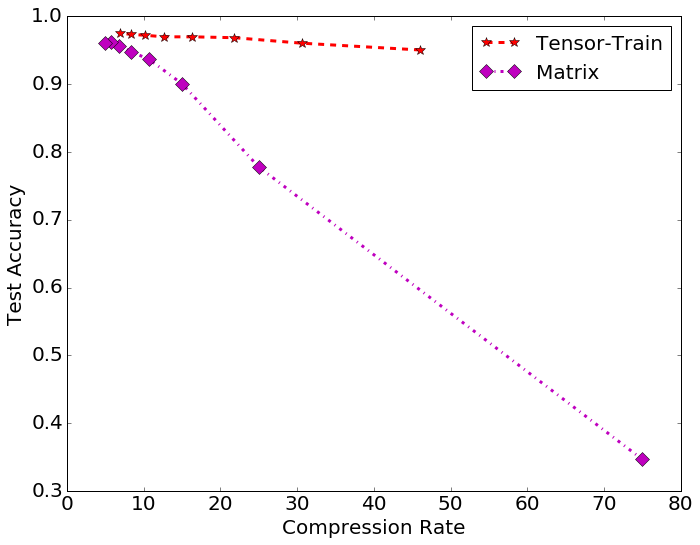

In [24]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(11, 8.5), dpi=600)
matplotlib.rcParams.update({'font.size': 20})
plt.plot( tt_compres, tt_prec, 'r*--', mf_compres, mf_prec, 'mD-.')
plt.legend(['Tensor-Train','Matrix'])
plt.xlabel('Compression Rate')
plt.ylabel('Test Accuracy')
plt.savefig('acc_ratio_fine_grained.pdf', format='pdf')